# Curvilinear grids


Parcels supports [curvilinear grids](https://www.nemo-ocean.eu/doc/node108.html) such as those used in the [NEMO models](https://www.nemo-ocean.eu/).

We will be using the example data in the `NemoCurvilinear_data/` directory. These fields are a purely zonal flow on an aqua-planet (so zonal-velocity is 1 m/s and meridional-velocity is 0 m/s everywhere, and no land). However, because of the curvilinear grid, the `U` and `V` fields vary north of 20N.


In [1]:
# from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import parcels

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_69939/1373545934.py:6: UserWarning: This is an alpha version of Parcels v4. The API is not stable and may change without deprecation warnings.
  import parcels


We can create a `FieldSet` just like we do for normal grids.
Note that NEMO is discretised on a C-grid. U and V velocities are not located on the same nodes (see https://www.nemo-ocean.eu/doc/node19.html ).

```
 __V1__
|      |
U0     U1
|__V0__|
```

To interpolate U, V velocities on the C-grid, Parcels needs to read the f-nodes, which are located on the corners of the cells (for indexing details: https://www.nemo-ocean.eu/doc/img360.png ).


In [2]:
data_folder = parcels.download_example_dataset("NemoCurvilinear_data")
files = data_folder.glob("*.nc4")
ds_fields = xr.open_mfdataset(files, combine="nested", data_vars="minimal", coords="minimal", compat="override")
ds_fields = (
    ds_fields.isel(time_counter=0, drop=True)
    .isel(time=0, drop=True)
    .isel(z_a=0, drop=True)
    .rename({"glamf": "lon", "gphif": "lat", "z": "depth"})
)

# TODO: replace manual fieldset creation with FieldSet.from_nemo() once available 
import xgcm
xgcm_grid = xgcm.Grid(
    ds_fields,
    coords={
        "X": {"left": "x"},
        "Y": {"left": "y"},
    },
    periodic=False,
    autoparse_metadata=False,
)
grid = parcels.XGrid(xgcm_grid, mesh="spherical")

U = parcels.Field("U", ds_fields["U"], grid, interp_method=parcels.interpolators.XLinear)
V = parcels.Field("V", ds_fields["V"], grid, interp_method=parcels.interpolators.XLinear)
U.units = parcels.GeographicPolar()
V.units = parcels.GeographicPolar()  # U and V need GeographicPolar for  C-Grid interpolation to work correctly
UV = parcels.VectorField("UV", U, V, vector_interp_method=parcels.interpolators.CGrid_Velocity)
fieldset = parcels.FieldSet([U, V, UV])

And we can plot the `U` field.


In [11]:
np.nanmin(fieldset.U.grid.lon)

np.float64(-179.99710083007812)

In [12]:
np.nanmax(fieldset.U.grid.lat)

np.float64(89.9376449584961)

/var/folders/fd/p7j_05zx409dzmtfjjjnjgfh0000gn/T/ipykernel_69939/2261245401.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(


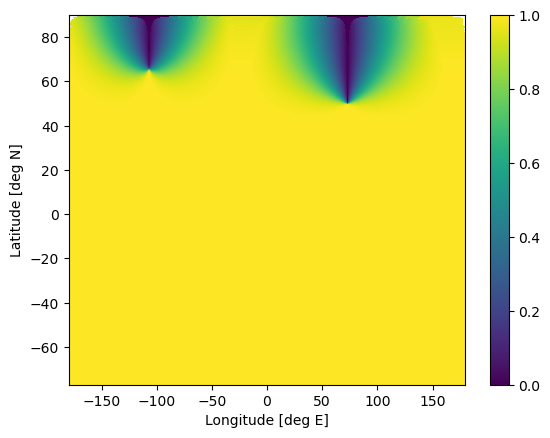

In [3]:
plt.pcolormesh(
    fieldset.U.grid.lon,
    fieldset.U.grid.lat,
    fieldset.U.data[0, 0, :, :],
    vmin=0,
    vmax=1,
)
plt.xlabel('Longitude [deg E]')
plt.ylabel("Latitude [deg N]")
plt.colorbar()
plt.show()

As you see above, the `U` field indeed is 1 m/s south of 20N, but varies with longitude and latitude north of that. We can confirm by doing a field evaluation at (60N, 50E):

In [4]:
u, v = fieldset.UV.eval(np.array([0]), np.array([0]), np.array([20]), np.array([50]), applyConversion=False) # do not convert m/s to deg/s
print(f"(u, v) = ({u[0]:.3f}, {v[0]:.3f})")
assert np.isclose(u, 1.0, atol=1e-3)

(u, v) = (1.000, 0.000)


Now we can run particles as normal. Parcels will take care to rotate the `U` and `V` fields.

In [ ]:
npart = 20
lonp = 30 * np.ones(npart)
latp = np.linspace(-70, 88, npart)
runtime = np.timedelta64(30, "D")

def periodicBC(particles, fieldset):  # pragma: no cover
    particles.dlon = np.where(particles.lon + particles.dlon > 180, particles.dlon - 360, particles.dlon)

pset = parcels.ParticleSet(fieldset, lon=lonp, lat=latp)
pfile = parcels.ParticleFile(store="output_curvilinear.zarr", outputdt=np.timedelta64(1,'D'))

pset.execute([parcels.kernels.AdvectionEE, periodicBC], runtime=runtime, dt=np.timedelta64(12, "h")) #, ,periodicBC, output_file=pfile
np.testing.assert_allclose(pset.lat, latp, atol=1e-1)

Integration time: 0 seconds:   0%|          | 0/2592000.0 [00:00<?, ?it/s][30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
 30. 30.]
[31.136684 30.819616 30.651567 30.550308 30.485117 30.442047 30.413998
 30.397146 30.389484 30.390162 30.39925  30.417768 30.447964 30.494066
 30.563969 30.673378 30.857672 31.216948 32.171673 41.15559 ]
[32.27337  31.639233 31.303135 31.100616 30.970234 30.884094 30.827995
 30.794292 30.778969 30.780323 30.7985   30.835537 30.895927 30.988132
 31.127924 31.346748 31.715654 32.43294  34.34293  52.315586]
[33.410053 32.458847 31.954702 31.650925 31.45535  31.326141 31.241993
 31.191439 31.168453 31.170485 31.19775  31.253305 31.343891 31.482197
 31.69189  32.01999  32.573444 33.650524 36.513306 63.421543]
[34.546738 33.27846  32.60627  32.201233 31.940468 31.768188 31.65599
 31.588585 31.557938 31.560646 31.597    31.671074 31.791855 31.976261
 32.255844 32.693417 33.431503 34.868183 38.685963 74.540665]
[35.683422 34.098076 33.2578

GridSearchingError: Grid searching failed at (z=[0.], lat=[88.002014], lon=[-177.97055])

And then we can plot these trajectories. As expected, all trajectories go exactly zonal and due to the curvature of the earth, ones at higher latitude move more degrees eastward (even though the distance in km is equal for all particles).


In [ ]:
ds = xr.open_zarr("output_curvilinear.zarr")

plt.plot(ds.lon.T, ds.lat.T, ".-")
plt.show()

FileNotFoundError: No such file or directory: '/Users/Gebruiker/Documents/UU/parcels/Parcels/docs/user_guide/examples_v3/nemo_particles.zarr'

## Speeding up `ParticleSet` initialisation by efficiently finding particle start-locations on the `Grid`

On a Curvilinear grid, determining the location of each `Particle` on the grid is more complicated and therefore takes longer than on a Rectilinear grid. Since Parcels version 2.2.2, a function is available on the `ParticleSet` class, that speeds up the look-up. After creating the `ParticleSet`, but before running the `ParticleSet.execute()`, simply call the function `ParticleSet.populate_indices()`.


In [ ]:
pset = parcels.ParticleSet.from_list(fieldset, parcels.Particle, lon=lonp, lat=latp)
pset.populate_indices()